# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

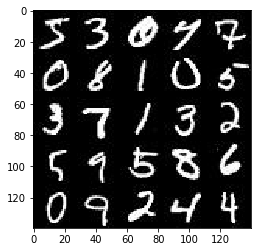

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

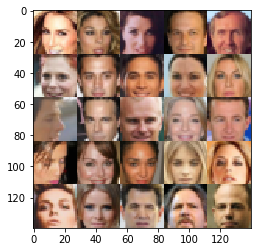

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1


G:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name = 'inputs')
    z_data = tf.placeholder(tf.float32, [None, z_dim], name ='z_data')
    learning_rate = tf.placeholder(tf.float32 , name = 'learning_rate')
    return input_real, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse = reuse):
        alpha = 0.2
        keep_prob = 0.8
        x1 = tf.layers.conv2d(images, 128, 5,strides = 2, padding = 'same', kernel_initializer = tf.contrib.layers.xavier_initializer())
        n1 = tf.layers.batch_normalization(x1, training = True)
        relu1 = tf.maximum(alpha * n1, n1)
        dropout1 = tf.nn.dropout(relu1, keep_prob)
        #16x16x128
        x2 = tf.layers.conv2d(images, 256, 5,strides = 2, padding = 'same', kernel_initializer = tf.contrib.layers.xavier_initializer())
        n2 = tf.layers.batch_normalization(x2, training = True)
        relu2 = tf.maximum(alpha * n2, n2)
        dropout2 = tf.nn.dropout(relu2, keep_prob)
        #8x8x256
        x3 = tf.layers.conv2d(images, 512, 5,strides = 2, padding = 'same', kernel_initializer = tf.contrib.layers.xavier_initializer())
        n3 = tf.layers.batch_normalization(x3, training = True)
        relu3 = tf.maximum(alpha * n3, n3)
        dropout3 = tf.nn.dropout(relu3, keep_prob)
        #4x4x512
        flat = tf.contrib.layers.flatten(dropout3)
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    alpha = 0.1
    with tf.variable_scope('generator', reuse = reuse):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha*x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides = 1,padding = 'same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_images_stream, z_data, lrate = model_inputs(data_shape[1],
                                                     data_shape[2],
                                                     data_shape[3],
                                                     z_dim)
    d_loss, g_loss = model_loss(real_images_stream, z_data, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lrate, beta1)
    
    verbosity_show = 100
    verbosity_loss = 10
    step = 1
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                _ = sess.run(d_train_opt, feed_dict={real_images_stream: batch_images,
                                                     z_data: batch_z, lrate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_data: batch_z, 
                                                     real_images_stream: batch_images,
                                                     lrate: learning_rate})
                if ((step % verbosity_loss) == 0):
                    d_loss_val = d_loss.eval({z_data: batch_z, real_images_stream: batch_images})
                    g_loss_val = g_loss.eval({z_data: batch_z})
                    print("Epoch {}/{}.\t".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}; ".format(d_loss_val),
                          "Generator Loss: {:.4f}".format(g_loss_val))
                if ((step % verbosity_show) == 0):
                    show_generator_output(sess, 25, z_data, data_shape[3], data_image_mode)
                    

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2.	 Discriminator Loss: 0.5107;  Generator Loss: 2.4840
Epoch 1/2.	 Discriminator Loss: 0.4142;  Generator Loss: 3.8957
Epoch 1/2.	 Discriminator Loss: 0.4095;  Generator Loss: 3.3150
Epoch 1/2.	 Discriminator Loss: 0.6176;  Generator Loss: 1.8890
Epoch 1/2.	 Discriminator Loss: 1.1486;  Generator Loss: 0.9617
Epoch 1/2.	 Discriminator Loss: 0.7968;  Generator Loss: 2.8642
Epoch 1/2.	 Discriminator Loss: 2.1690;  Generator Loss: 0.2521
Epoch 1/2.	 Discriminator Loss: 0.7797;  Generator Loss: 1.4453
Epoch 1/2.	 Discriminator Loss: 1.4933;  Generator Loss: 1.3781
Epoch 1/2.	 Discriminator Loss: 1.2188;  Generator Loss: 1.1933


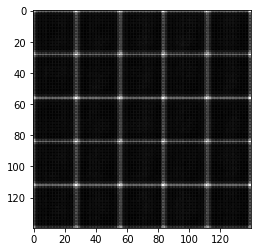

Epoch 1/2.	 Discriminator Loss: 1.2222;  Generator Loss: 1.2662
Epoch 1/2.	 Discriminator Loss: 1.2832;  Generator Loss: 1.3099
Epoch 1/2.	 Discriminator Loss: 1.0243;  Generator Loss: 1.1707
Epoch 1/2.	 Discriminator Loss: 0.8938;  Generator Loss: 1.2865
Epoch 1/2.	 Discriminator Loss: 1.0322;  Generator Loss: 1.0304
Epoch 1/2.	 Discriminator Loss: 1.0342;  Generator Loss: 1.1441
Epoch 1/2.	 Discriminator Loss: 1.2285;  Generator Loss: 1.0166
Epoch 1/2.	 Discriminator Loss: 1.3506;  Generator Loss: 0.7748
Epoch 1/2.	 Discriminator Loss: 1.2383;  Generator Loss: 1.0879
Epoch 1/2.	 Discriminator Loss: 1.3548;  Generator Loss: 0.7445


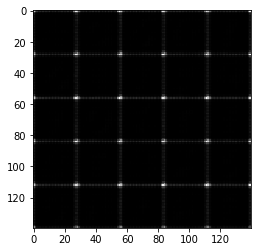

Epoch 1/2.	 Discriminator Loss: 1.5218;  Generator Loss: 1.4307
Epoch 1/2.	 Discriminator Loss: 1.4330;  Generator Loss: 0.5839
Epoch 1/2.	 Discriminator Loss: 1.4445;  Generator Loss: 0.7698
Epoch 1/2.	 Discriminator Loss: 1.4865;  Generator Loss: 1.0843
Epoch 1/2.	 Discriminator Loss: 1.4594;  Generator Loss: 0.7689
Epoch 1/2.	 Discriminator Loss: 1.4640;  Generator Loss: 0.6572
Epoch 1/2.	 Discriminator Loss: 1.6452;  Generator Loss: 0.6503
Epoch 1/2.	 Discriminator Loss: 1.6725;  Generator Loss: 1.1215
Epoch 1/2.	 Discriminator Loss: 1.6384;  Generator Loss: 0.7174
Epoch 1/2.	 Discriminator Loss: 1.5047;  Generator Loss: 0.7019


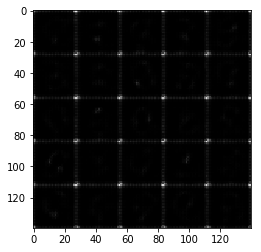

Epoch 1/2.	 Discriminator Loss: 1.6962;  Generator Loss: 0.9016
Epoch 1/2.	 Discriminator Loss: 1.6139;  Generator Loss: 0.5415
Epoch 1/2.	 Discriminator Loss: 1.5794;  Generator Loss: 0.5767
Epoch 1/2.	 Discriminator Loss: 1.5732;  Generator Loss: 0.6250
Epoch 1/2.	 Discriminator Loss: 1.5173;  Generator Loss: 0.7976
Epoch 1/2.	 Discriminator Loss: 1.4817;  Generator Loss: 0.5987
Epoch 1/2.	 Discriminator Loss: 1.6636;  Generator Loss: 0.4623
Epoch 1/2.	 Discriminator Loss: 1.3946;  Generator Loss: 1.0579
Epoch 1/2.	 Discriminator Loss: 1.6020;  Generator Loss: 0.5090
Epoch 1/2.	 Discriminator Loss: 1.8393;  Generator Loss: 0.4173


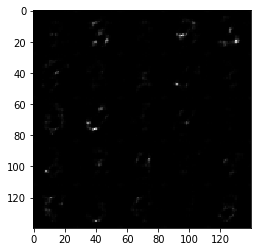

Epoch 1/2.	 Discriminator Loss: 1.3945;  Generator Loss: 0.6507
Epoch 1/2.	 Discriminator Loss: 1.3722;  Generator Loss: 0.6354
Epoch 1/2.	 Discriminator Loss: 1.3653;  Generator Loss: 0.7377
Epoch 1/2.	 Discriminator Loss: 1.4276;  Generator Loss: 0.6573
Epoch 1/2.	 Discriminator Loss: 1.4871;  Generator Loss: 0.6723
Epoch 1/2.	 Discriminator Loss: 1.2677;  Generator Loss: 1.2017
Epoch 1/2.	 Discriminator Loss: 1.3751;  Generator Loss: 1.2630
Epoch 1/2.	 Discriminator Loss: 1.6201;  Generator Loss: 0.4653
Epoch 1/2.	 Discriminator Loss: 1.6826;  Generator Loss: 0.4648
Epoch 1/2.	 Discriminator Loss: 1.5099;  Generator Loss: 0.6533


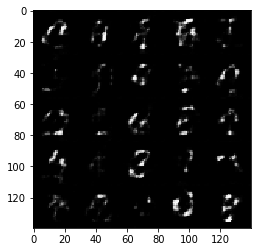

Epoch 1/2.	 Discriminator Loss: 1.5719;  Generator Loss: 0.4774
Epoch 1/2.	 Discriminator Loss: 1.6587;  Generator Loss: 0.4516
Epoch 1/2.	 Discriminator Loss: 1.4662;  Generator Loss: 1.1472
Epoch 1/2.	 Discriminator Loss: 1.2678;  Generator Loss: 0.9283
Epoch 1/2.	 Discriminator Loss: 1.3121;  Generator Loss: 0.7975
Epoch 1/2.	 Discriminator Loss: 1.3970;  Generator Loss: 0.9280
Epoch 1/2.	 Discriminator Loss: 1.4386;  Generator Loss: 0.6710
Epoch 1/2.	 Discriminator Loss: 1.2891;  Generator Loss: 1.1250
Epoch 1/2.	 Discriminator Loss: 1.3388;  Generator Loss: 1.4021
Epoch 1/2.	 Discriminator Loss: 1.3524;  Generator Loss: 1.1205


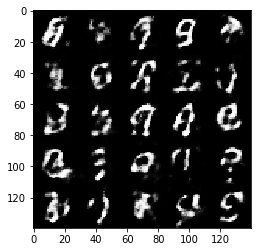

Epoch 1/2.	 Discriminator Loss: 1.4541;  Generator Loss: 1.0534
Epoch 1/2.	 Discriminator Loss: 1.4178;  Generator Loss: 0.5483
Epoch 1/2.	 Discriminator Loss: 1.4096;  Generator Loss: 0.6076
Epoch 1/2.	 Discriminator Loss: 1.2825;  Generator Loss: 0.8145
Epoch 1/2.	 Discriminator Loss: 1.3481;  Generator Loss: 0.7464
Epoch 1/2.	 Discriminator Loss: 1.3604;  Generator Loss: 1.0064
Epoch 1/2.	 Discriminator Loss: 1.4531;  Generator Loss: 1.0456
Epoch 1/2.	 Discriminator Loss: 1.3586;  Generator Loss: 1.0021
Epoch 1/2.	 Discriminator Loss: 1.4564;  Generator Loss: 1.0111
Epoch 1/2.	 Discriminator Loss: 1.3512;  Generator Loss: 0.7040


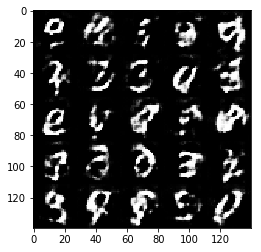

Epoch 1/2.	 Discriminator Loss: 1.4766;  Generator Loss: 0.5694
Epoch 1/2.	 Discriminator Loss: 1.3249;  Generator Loss: 0.6789
Epoch 1/2.	 Discriminator Loss: 1.2746;  Generator Loss: 1.1162
Epoch 1/2.	 Discriminator Loss: 1.4283;  Generator Loss: 1.1148
Epoch 1/2.	 Discriminator Loss: 1.3113;  Generator Loss: 0.7869
Epoch 1/2.	 Discriminator Loss: 1.3533;  Generator Loss: 0.6731
Epoch 1/2.	 Discriminator Loss: 1.3818;  Generator Loss: 0.9635
Epoch 1/2.	 Discriminator Loss: 1.2833;  Generator Loss: 0.9759
Epoch 1/2.	 Discriminator Loss: 1.2621;  Generator Loss: 0.9335
Epoch 1/2.	 Discriminator Loss: 1.3633;  Generator Loss: 0.6480


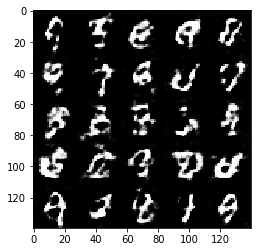

Epoch 1/2.	 Discriminator Loss: 1.3740;  Generator Loss: 0.7340
Epoch 1/2.	 Discriminator Loss: 1.2954;  Generator Loss: 0.8758
Epoch 1/2.	 Discriminator Loss: 1.2783;  Generator Loss: 0.6880
Epoch 1/2.	 Discriminator Loss: 1.3175;  Generator Loss: 0.7774
Epoch 1/2.	 Discriminator Loss: 1.2471;  Generator Loss: 1.0694
Epoch 1/2.	 Discriminator Loss: 1.2904;  Generator Loss: 1.2995
Epoch 1/2.	 Discriminator Loss: 1.2079;  Generator Loss: 0.9317
Epoch 1/2.	 Discriminator Loss: 1.2931;  Generator Loss: 0.8798
Epoch 1/2.	 Discriminator Loss: 1.3360;  Generator Loss: 0.6426
Epoch 1/2.	 Discriminator Loss: 1.2950;  Generator Loss: 0.6302


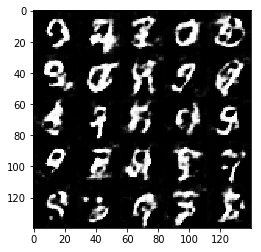

Epoch 1/2.	 Discriminator Loss: 1.4247;  Generator Loss: 0.5241
Epoch 1/2.	 Discriminator Loss: 1.2709;  Generator Loss: 0.7583
Epoch 1/2.	 Discriminator Loss: 1.3595;  Generator Loss: 0.6688
Epoch 2/2.	 Discriminator Loss: 1.2329;  Generator Loss: 1.0489
Epoch 2/2.	 Discriminator Loss: 1.3193;  Generator Loss: 1.0453
Epoch 2/2.	 Discriminator Loss: 1.4451;  Generator Loss: 0.4683
Epoch 2/2.	 Discriminator Loss: 1.3013;  Generator Loss: 0.6814
Epoch 2/2.	 Discriminator Loss: 1.4257;  Generator Loss: 0.5282
Epoch 2/2.	 Discriminator Loss: 1.2754;  Generator Loss: 0.6849
Epoch 2/2.	 Discriminator Loss: 1.2350;  Generator Loss: 1.0208


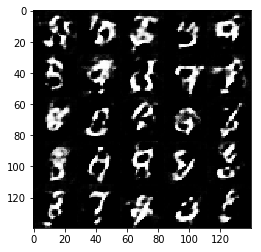

Epoch 2/2.	 Discriminator Loss: 1.3308;  Generator Loss: 1.2750
Epoch 2/2.	 Discriminator Loss: 1.2035;  Generator Loss: 1.3955
Epoch 2/2.	 Discriminator Loss: 1.3098;  Generator Loss: 0.6352
Epoch 2/2.	 Discriminator Loss: 1.1983;  Generator Loss: 0.7862
Epoch 2/2.	 Discriminator Loss: 1.2546;  Generator Loss: 0.6854
Epoch 2/2.	 Discriminator Loss: 1.4048;  Generator Loss: 0.5196
Epoch 2/2.	 Discriminator Loss: 1.4401;  Generator Loss: 0.4986
Epoch 2/2.	 Discriminator Loss: 1.2917;  Generator Loss: 0.7296
Epoch 2/2.	 Discriminator Loss: 1.3486;  Generator Loss: 0.5972
Epoch 2/2.	 Discriminator Loss: 1.2067;  Generator Loss: 1.1226


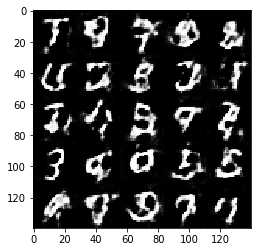

Epoch 2/2.	 Discriminator Loss: 1.3813;  Generator Loss: 0.6216
Epoch 2/2.	 Discriminator Loss: 1.2821;  Generator Loss: 1.0253
Epoch 2/2.	 Discriminator Loss: 1.2081;  Generator Loss: 0.9132
Epoch 2/2.	 Discriminator Loss: 1.2539;  Generator Loss: 0.6968
Epoch 2/2.	 Discriminator Loss: 1.2043;  Generator Loss: 1.0210
Epoch 2/2.	 Discriminator Loss: 1.3956;  Generator Loss: 0.5335
Epoch 2/2.	 Discriminator Loss: 1.3285;  Generator Loss: 0.9258
Epoch 2/2.	 Discriminator Loss: 1.3277;  Generator Loss: 0.6314
Epoch 2/2.	 Discriminator Loss: 1.1841;  Generator Loss: 0.7580
Epoch 2/2.	 Discriminator Loss: 1.2412;  Generator Loss: 0.8176


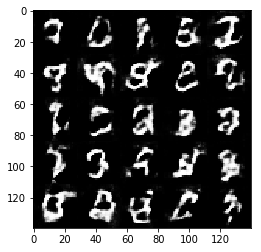

Epoch 2/2.	 Discriminator Loss: 1.2945;  Generator Loss: 0.6231
Epoch 2/2.	 Discriminator Loss: 1.5123;  Generator Loss: 0.4562
Epoch 2/2.	 Discriminator Loss: 1.2292;  Generator Loss: 1.0337
Epoch 2/2.	 Discriminator Loss: 1.2766;  Generator Loss: 1.0297
Epoch 2/2.	 Discriminator Loss: 1.4261;  Generator Loss: 0.5212
Epoch 2/2.	 Discriminator Loss: 1.1776;  Generator Loss: 0.9899
Epoch 2/2.	 Discriminator Loss: 1.1955;  Generator Loss: 1.0492
Epoch 2/2.	 Discriminator Loss: 1.2832;  Generator Loss: 0.6692
Epoch 2/2.	 Discriminator Loss: 1.2319;  Generator Loss: 0.9702
Epoch 2/2.	 Discriminator Loss: 1.2331;  Generator Loss: 0.6655


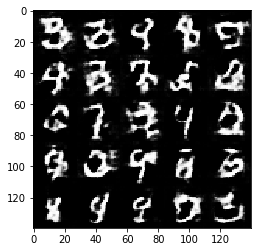

Epoch 2/2.	 Discriminator Loss: 1.2587;  Generator Loss: 1.1997
Epoch 2/2.	 Discriminator Loss: 1.6366;  Generator Loss: 1.8283
Epoch 2/2.	 Discriminator Loss: 1.3304;  Generator Loss: 0.6458
Epoch 2/2.	 Discriminator Loss: 1.2813;  Generator Loss: 0.8507
Epoch 2/2.	 Discriminator Loss: 1.3099;  Generator Loss: 0.7201
Epoch 2/2.	 Discriminator Loss: 1.4664;  Generator Loss: 0.4733
Epoch 2/2.	 Discriminator Loss: 1.3235;  Generator Loss: 0.6468
Epoch 2/2.	 Discriminator Loss: 1.4223;  Generator Loss: 0.5177
Epoch 2/2.	 Discriminator Loss: 1.2825;  Generator Loss: 0.6696
Epoch 2/2.	 Discriminator Loss: 1.2417;  Generator Loss: 1.1744


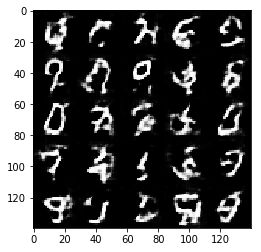

Epoch 2/2.	 Discriminator Loss: 1.2463;  Generator Loss: 0.7257
Epoch 2/2.	 Discriminator Loss: 1.1968;  Generator Loss: 1.2126
Epoch 2/2.	 Discriminator Loss: 1.2478;  Generator Loss: 1.4047
Epoch 2/2.	 Discriminator Loss: 1.4192;  Generator Loss: 0.5379
Epoch 2/2.	 Discriminator Loss: 1.4359;  Generator Loss: 1.4998
Epoch 2/2.	 Discriminator Loss: 1.3643;  Generator Loss: 1.5946
Epoch 2/2.	 Discriminator Loss: 1.3110;  Generator Loss: 1.2920
Epoch 2/2.	 Discriminator Loss: 1.3236;  Generator Loss: 1.6219
Epoch 2/2.	 Discriminator Loss: 1.2418;  Generator Loss: 1.3041
Epoch 2/2.	 Discriminator Loss: 1.2731;  Generator Loss: 1.4296


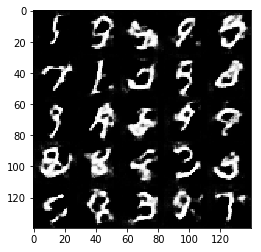

Epoch 2/2.	 Discriminator Loss: 1.1265;  Generator Loss: 1.3552
Epoch 2/2.	 Discriminator Loss: 1.2911;  Generator Loss: 1.4444
Epoch 2/2.	 Discriminator Loss: 1.3042;  Generator Loss: 1.3792
Epoch 2/2.	 Discriminator Loss: 1.2473;  Generator Loss: 1.5824
Epoch 2/2.	 Discriminator Loss: 1.1690;  Generator Loss: 1.1862
Epoch 2/2.	 Discriminator Loss: 1.2733;  Generator Loss: 1.1784
Epoch 2/2.	 Discriminator Loss: 1.3373;  Generator Loss: 1.5110
Epoch 2/2.	 Discriminator Loss: 1.2110;  Generator Loss: 1.1559
Epoch 2/2.	 Discriminator Loss: 1.2481;  Generator Loss: 1.3134
Epoch 2/2.	 Discriminator Loss: 1.4233;  Generator Loss: 1.6253


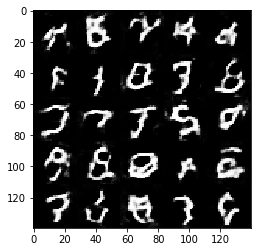

Epoch 2/2.	 Discriminator Loss: 1.2610;  Generator Loss: 1.1358
Epoch 2/2.	 Discriminator Loss: 1.2710;  Generator Loss: 0.8656
Epoch 2/2.	 Discriminator Loss: 1.2517;  Generator Loss: 0.8575
Epoch 2/2.	 Discriminator Loss: 1.2674;  Generator Loss: 0.7260
Epoch 2/2.	 Discriminator Loss: 1.2642;  Generator Loss: 0.8448
Epoch 2/2.	 Discriminator Loss: 1.3128;  Generator Loss: 1.2953
Epoch 2/2.	 Discriminator Loss: 1.2777;  Generator Loss: 0.8456
Epoch 2/2.	 Discriminator Loss: 1.4771;  Generator Loss: 0.4835
Epoch 2/2.	 Discriminator Loss: 1.4085;  Generator Loss: 0.5061
Epoch 2/2.	 Discriminator Loss: 1.3462;  Generator Loss: 0.5670


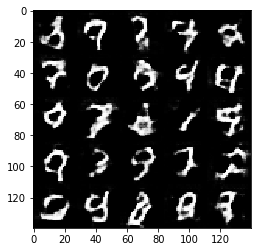

Epoch 2/2.	 Discriminator Loss: 1.1699;  Generator Loss: 0.7372
Epoch 2/2.	 Discriminator Loss: 1.2502;  Generator Loss: 0.8773
Epoch 2/2.	 Discriminator Loss: 1.2375;  Generator Loss: 1.3308
Epoch 2/2.	 Discriminator Loss: 1.3240;  Generator Loss: 1.2393
Epoch 2/2.	 Discriminator Loss: 1.3491;  Generator Loss: 1.3469
Epoch 2/2.	 Discriminator Loss: 1.2952;  Generator Loss: 1.1421
Epoch 2/2.	 Discriminator Loss: 1.3226;  Generator Loss: 0.8913
Epoch 2/2.	 Discriminator Loss: 1.3478;  Generator Loss: 0.5883
Epoch 2/2.	 Discriminator Loss: 1.2910;  Generator Loss: 0.7064
Epoch 2/2.	 Discriminator Loss: 1.2267;  Generator Loss: 1.4645


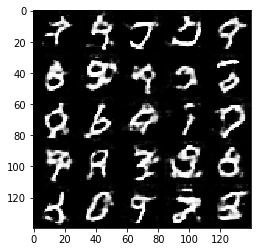

Epoch 2/2.	 Discriminator Loss: 1.2921;  Generator Loss: 0.9011
Epoch 2/2.	 Discriminator Loss: 1.3139;  Generator Loss: 0.7511
Epoch 2/2.	 Discriminator Loss: 1.3061;  Generator Loss: 0.6796
Epoch 2/2.	 Discriminator Loss: 1.2790;  Generator Loss: 0.8485
Epoch 2/2.	 Discriminator Loss: 1.2783;  Generator Loss: 0.7679
Epoch 2/2.	 Discriminator Loss: 1.3667;  Generator Loss: 1.3808
Epoch 2/2.	 Discriminator Loss: 1.3797;  Generator Loss: 1.4718


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1.	 Discriminator Loss: 2.1485;  Generator Loss: 0.7871
Epoch 1/1.	 Discriminator Loss: 1.6265;  Generator Loss: 0.7175
Epoch 1/1.	 Discriminator Loss: 1.3546;  Generator Loss: 2.1429
Epoch 1/1.	 Discriminator Loss: 1.3397;  Generator Loss: 1.2528
Epoch 1/1.	 Discriminator Loss: 0.8514;  Generator Loss: 2.3288
Epoch 1/1.	 Discriminator Loss: 1.4043;  Generator Loss: 0.9028
Epoch 1/1.	 Discriminator Loss: 1.6154;  Generator Loss: 0.7347
Epoch 1/1.	 Discriminator Loss: 1.1316;  Generator Loss: 1.0900
Epoch 1/1.	 Discriminator Loss: 0.7588;  Generator Loss: 2.0498
Epoch 1/1.	 Discriminator Loss: 0.6859;  Generator Loss: 2.2100


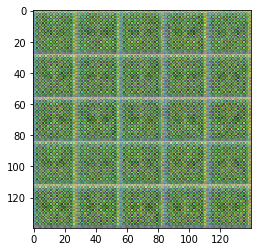

Epoch 1/1.	 Discriminator Loss: 0.5874;  Generator Loss: 2.3559
Epoch 1/1.	 Discriminator Loss: 0.4968;  Generator Loss: 3.3447
Epoch 1/1.	 Discriminator Loss: 0.5257;  Generator Loss: 2.7439
Epoch 1/1.	 Discriminator Loss: 0.4989;  Generator Loss: 2.4279
Epoch 1/1.	 Discriminator Loss: 0.4637;  Generator Loss: 3.2188
Epoch 1/1.	 Discriminator Loss: 0.4799;  Generator Loss: 3.4825
Epoch 1/1.	 Discriminator Loss: 0.5093;  Generator Loss: 2.7034
Epoch 1/1.	 Discriminator Loss: 0.4732;  Generator Loss: 3.3377
Epoch 1/1.	 Discriminator Loss: 0.4130;  Generator Loss: 3.3793
Epoch 1/1.	 Discriminator Loss: 0.4688;  Generator Loss: 2.9326


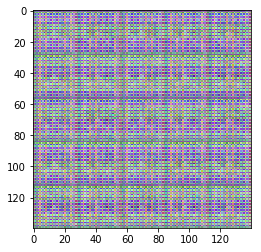

Epoch 1/1.	 Discriminator Loss: 0.7757;  Generator Loss: 1.1992
Epoch 1/1.	 Discriminator Loss: 0.3944;  Generator Loss: 3.5822
Epoch 1/1.	 Discriminator Loss: 0.4089;  Generator Loss: 3.5349
Epoch 1/1.	 Discriminator Loss: 0.4624;  Generator Loss: 2.5888
Epoch 1/1.	 Discriminator Loss: 0.5035;  Generator Loss: 2.3271
Epoch 1/1.	 Discriminator Loss: 0.6945;  Generator Loss: 4.7534
Epoch 1/1.	 Discriminator Loss: 1.2010;  Generator Loss: 1.1553
Epoch 1/1.	 Discriminator Loss: 1.2988;  Generator Loss: 2.4189
Epoch 1/1.	 Discriminator Loss: 1.0125;  Generator Loss: 1.5508
Epoch 1/1.	 Discriminator Loss: 1.0795;  Generator Loss: 1.0933


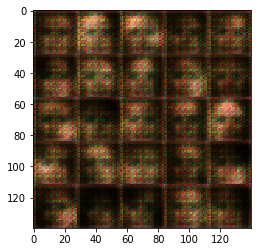

Epoch 1/1.	 Discriminator Loss: 1.0616;  Generator Loss: 1.8418
Epoch 1/1.	 Discriminator Loss: 1.0295;  Generator Loss: 4.1386
Epoch 1/1.	 Discriminator Loss: 1.0697;  Generator Loss: 2.2902
Epoch 1/1.	 Discriminator Loss: 1.1372;  Generator Loss: 1.6925
Epoch 1/1.	 Discriminator Loss: 0.7592;  Generator Loss: 2.6656
Epoch 1/1.	 Discriminator Loss: 1.0323;  Generator Loss: 1.3389
Epoch 1/1.	 Discriminator Loss: 1.0512;  Generator Loss: 1.4338
Epoch 1/1.	 Discriminator Loss: 0.9124;  Generator Loss: 1.9086
Epoch 1/1.	 Discriminator Loss: 0.7792;  Generator Loss: 1.8694
Epoch 1/1.	 Discriminator Loss: 1.0614;  Generator Loss: 1.9008


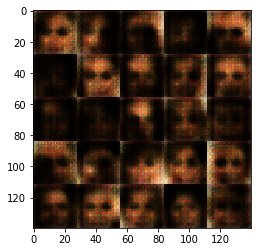

Epoch 1/1.	 Discriminator Loss: 1.0399;  Generator Loss: 1.4558
Epoch 1/1.	 Discriminator Loss: 1.0771;  Generator Loss: 1.0795
Epoch 1/1.	 Discriminator Loss: 1.1722;  Generator Loss: 0.9364
Epoch 1/1.	 Discriminator Loss: 1.1813;  Generator Loss: 2.9787
Epoch 1/1.	 Discriminator Loss: 1.6322;  Generator Loss: 0.5065
Epoch 1/1.	 Discriminator Loss: 1.2282;  Generator Loss: 0.7829
Epoch 1/1.	 Discriminator Loss: 2.2229;  Generator Loss: 0.3183
Epoch 1/1.	 Discriminator Loss: 1.1657;  Generator Loss: 1.0882
Epoch 1/1.	 Discriminator Loss: 1.3611;  Generator Loss: 0.6732
Epoch 1/1.	 Discriminator Loss: 2.1055;  Generator Loss: 0.2660


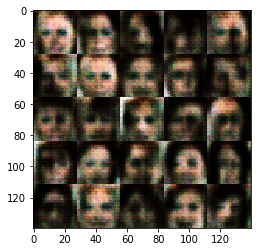

Epoch 1/1.	 Discriminator Loss: 1.4866;  Generator Loss: 0.6957
Epoch 1/1.	 Discriminator Loss: 1.4832;  Generator Loss: 1.8524
Epoch 1/1.	 Discriminator Loss: 1.0970;  Generator Loss: 1.0976
Epoch 1/1.	 Discriminator Loss: 1.1720;  Generator Loss: 0.8309
Epoch 1/1.	 Discriminator Loss: 1.3250;  Generator Loss: 0.6463
Epoch 1/1.	 Discriminator Loss: 1.0943;  Generator Loss: 1.0377
Epoch 1/1.	 Discriminator Loss: 0.8740;  Generator Loss: 1.6896
Epoch 1/1.	 Discriminator Loss: 1.2152;  Generator Loss: 2.3007
Epoch 1/1.	 Discriminator Loss: 0.9844;  Generator Loss: 1.2910
Epoch 1/1.	 Discriminator Loss: 1.1462;  Generator Loss: 0.9710


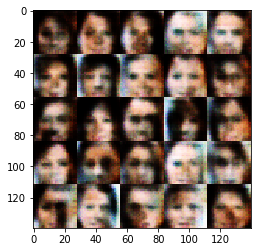

Epoch 1/1.	 Discriminator Loss: 1.3309;  Generator Loss: 1.1822
Epoch 1/1.	 Discriminator Loss: 1.1304;  Generator Loss: 0.9923
Epoch 1/1.	 Discriminator Loss: 1.5197;  Generator Loss: 4.7601
Epoch 1/1.	 Discriminator Loss: 1.1465;  Generator Loss: 2.4606
Epoch 1/1.	 Discriminator Loss: 0.9734;  Generator Loss: 1.8600
Epoch 1/1.	 Discriminator Loss: 1.1080;  Generator Loss: 2.8079
Epoch 1/1.	 Discriminator Loss: 1.0539;  Generator Loss: 2.2015
Epoch 1/1.	 Discriminator Loss: 1.6825;  Generator Loss: 0.3959
Epoch 1/1.	 Discriminator Loss: 1.9720;  Generator Loss: 0.3012
Epoch 1/1.	 Discriminator Loss: 1.4782;  Generator Loss: 0.4707


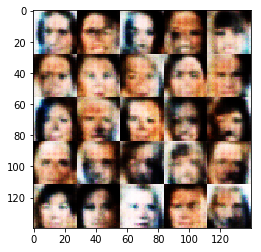

Epoch 1/1.	 Discriminator Loss: 1.6231;  Generator Loss: 3.4930
Epoch 1/1.	 Discriminator Loss: 0.9468;  Generator Loss: 1.2159
Epoch 1/1.	 Discriminator Loss: 0.8584;  Generator Loss: 1.4050
Epoch 1/1.	 Discriminator Loss: 1.4749;  Generator Loss: 0.5026
Epoch 1/1.	 Discriminator Loss: 0.9331;  Generator Loss: 1.8154
Epoch 1/1.	 Discriminator Loss: 0.8066;  Generator Loss: 1.8980
Epoch 1/1.	 Discriminator Loss: 1.3030;  Generator Loss: 2.7586
Epoch 1/1.	 Discriminator Loss: 0.9614;  Generator Loss: 2.3442
Epoch 1/1.	 Discriminator Loss: 0.9906;  Generator Loss: 1.3079
Epoch 1/1.	 Discriminator Loss: 1.1538;  Generator Loss: 3.2418


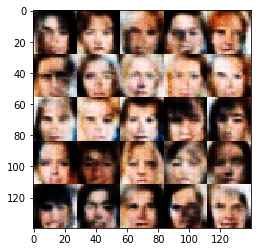

Epoch 1/1.	 Discriminator Loss: 1.0467;  Generator Loss: 2.3813
Epoch 1/1.	 Discriminator Loss: 1.0764;  Generator Loss: 1.0159
Epoch 1/1.	 Discriminator Loss: 1.1049;  Generator Loss: 1.2741
Epoch 1/1.	 Discriminator Loss: 2.5370;  Generator Loss: 0.1720
Epoch 1/1.	 Discriminator Loss: 1.3475;  Generator Loss: 0.8437
Epoch 1/1.	 Discriminator Loss: 1.3126;  Generator Loss: 0.6975
Epoch 1/1.	 Discriminator Loss: 1.0073;  Generator Loss: 3.2388
Epoch 1/1.	 Discriminator Loss: 1.1583;  Generator Loss: 1.6103
Epoch 1/1.	 Discriminator Loss: 1.7806;  Generator Loss: 0.4187
Epoch 1/1.	 Discriminator Loss: 1.6049;  Generator Loss: 0.4499


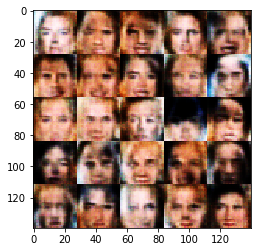

Epoch 1/1.	 Discriminator Loss: 1.2340;  Generator Loss: 1.0429
Epoch 1/1.	 Discriminator Loss: 1.2504;  Generator Loss: 2.7649
Epoch 1/1.	 Discriminator Loss: 1.2080;  Generator Loss: 0.9667
Epoch 1/1.	 Discriminator Loss: 1.2269;  Generator Loss: 0.6849
Epoch 1/1.	 Discriminator Loss: 1.2613;  Generator Loss: 0.6592
Epoch 1/1.	 Discriminator Loss: 1.6542;  Generator Loss: 0.4600
Epoch 1/1.	 Discriminator Loss: 1.0411;  Generator Loss: 1.2663
Epoch 1/1.	 Discriminator Loss: 0.9822;  Generator Loss: 1.1195
Epoch 1/1.	 Discriminator Loss: 0.9842;  Generator Loss: 1.3947
Epoch 1/1.	 Discriminator Loss: 1.0337;  Generator Loss: 1.3767


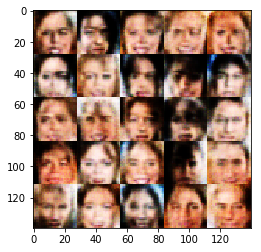

Epoch 1/1.	 Discriminator Loss: 1.2466;  Generator Loss: 3.6489
Epoch 1/1.	 Discriminator Loss: 1.0381;  Generator Loss: 1.9843
Epoch 1/1.	 Discriminator Loss: 0.7815;  Generator Loss: 1.8413
Epoch 1/1.	 Discriminator Loss: 1.0185;  Generator Loss: 3.3027
Epoch 1/1.	 Discriminator Loss: 1.6744;  Generator Loss: 0.4160
Epoch 1/1.	 Discriminator Loss: 1.1857;  Generator Loss: 2.3798
Epoch 1/1.	 Discriminator Loss: 1.1514;  Generator Loss: 0.8258
Epoch 1/1.	 Discriminator Loss: 0.7616;  Generator Loss: 2.1298
Epoch 1/1.	 Discriminator Loss: 1.2340;  Generator Loss: 2.7859
Epoch 1/1.	 Discriminator Loss: 1.2773;  Generator Loss: 2.9048


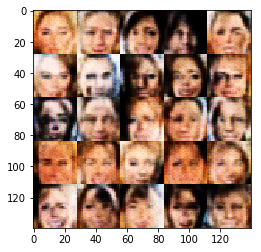

Epoch 1/1.	 Discriminator Loss: 1.3724;  Generator Loss: 0.6253
Epoch 1/1.	 Discriminator Loss: 1.7224;  Generator Loss: 0.4029
Epoch 1/1.	 Discriminator Loss: 1.9714;  Generator Loss: 0.2810
Epoch 1/1.	 Discriminator Loss: 1.4388;  Generator Loss: 0.5417
Epoch 1/1.	 Discriminator Loss: 1.0571;  Generator Loss: 1.7284
Epoch 1/1.	 Discriminator Loss: 0.9890;  Generator Loss: 1.2368
Epoch 1/1.	 Discriminator Loss: 0.9627;  Generator Loss: 1.8280
Epoch 1/1.	 Discriminator Loss: 1.0817;  Generator Loss: 2.6641
Epoch 1/1.	 Discriminator Loss: 0.8938;  Generator Loss: 1.7244
Epoch 1/1.	 Discriminator Loss: 0.9844;  Generator Loss: 1.8370


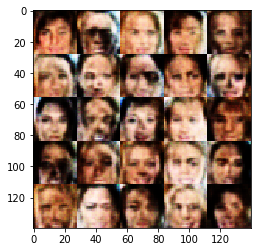

Epoch 1/1.	 Discriminator Loss: 1.1351;  Generator Loss: 1.0040
Epoch 1/1.	 Discriminator Loss: 1.1934;  Generator Loss: 3.5627
Epoch 1/1.	 Discriminator Loss: 0.9309;  Generator Loss: 1.7323
Epoch 1/1.	 Discriminator Loss: 2.2569;  Generator Loss: 0.2133
Epoch 1/1.	 Discriminator Loss: 0.8673;  Generator Loss: 1.7503
Epoch 1/1.	 Discriminator Loss: 0.9235;  Generator Loss: 2.6354
Epoch 1/1.	 Discriminator Loss: 2.0937;  Generator Loss: 0.2327
Epoch 1/1.	 Discriminator Loss: 0.9272;  Generator Loss: 2.3230
Epoch 1/1.	 Discriminator Loss: 1.2958;  Generator Loss: 0.8181
Epoch 1/1.	 Discriminator Loss: 0.9725;  Generator Loss: 1.2832


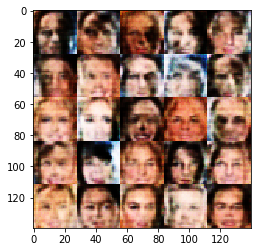

Epoch 1/1.	 Discriminator Loss: 1.0067;  Generator Loss: 1.2378
Epoch 1/1.	 Discriminator Loss: 1.6903;  Generator Loss: 0.3875
Epoch 1/1.	 Discriminator Loss: 1.1110;  Generator Loss: 1.1271
Epoch 1/1.	 Discriminator Loss: 1.3325;  Generator Loss: 2.3258
Epoch 1/1.	 Discriminator Loss: 0.9550;  Generator Loss: 2.7294
Epoch 1/1.	 Discriminator Loss: 1.1162;  Generator Loss: 0.8468
Epoch 1/1.	 Discriminator Loss: 1.5595;  Generator Loss: 3.0668
Epoch 1/1.	 Discriminator Loss: 1.2280;  Generator Loss: 2.8264
Epoch 1/1.	 Discriminator Loss: 1.0749;  Generator Loss: 2.5509
Epoch 1/1.	 Discriminator Loss: 1.2710;  Generator Loss: 3.2328


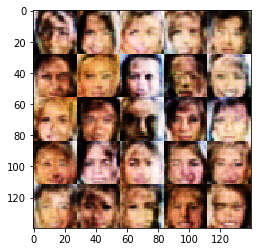

Epoch 1/1.	 Discriminator Loss: 0.9962;  Generator Loss: 2.0715
Epoch 1/1.	 Discriminator Loss: 1.4131;  Generator Loss: 1.5198
Epoch 1/1.	 Discriminator Loss: 1.2068;  Generator Loss: 2.8762
Epoch 1/1.	 Discriminator Loss: 1.5398;  Generator Loss: 0.5206
Epoch 1/1.	 Discriminator Loss: 1.4582;  Generator Loss: 3.7997
Epoch 1/1.	 Discriminator Loss: 0.9216;  Generator Loss: 2.2162
Epoch 1/1.	 Discriminator Loss: 1.6459;  Generator Loss: 0.4298
Epoch 1/1.	 Discriminator Loss: 1.3543;  Generator Loss: 0.5891
Epoch 1/1.	 Discriminator Loss: 1.1572;  Generator Loss: 1.8850
Epoch 1/1.	 Discriminator Loss: 1.6808;  Generator Loss: 0.5296


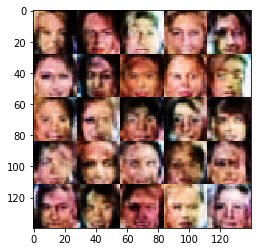

Epoch 1/1.	 Discriminator Loss: 1.2895;  Generator Loss: 0.7089
Epoch 1/1.	 Discriminator Loss: 1.0577;  Generator Loss: 2.0930
Epoch 1/1.	 Discriminator Loss: 0.8013;  Generator Loss: 1.9051
Epoch 1/1.	 Discriminator Loss: 0.9508;  Generator Loss: 1.6505
Epoch 1/1.	 Discriminator Loss: 0.8573;  Generator Loss: 1.5154
Epoch 1/1.	 Discriminator Loss: 0.8654;  Generator Loss: 2.4319
Epoch 1/1.	 Discriminator Loss: 1.1439;  Generator Loss: 0.8945
Epoch 1/1.	 Discriminator Loss: 1.1344;  Generator Loss: 1.0667
Epoch 1/1.	 Discriminator Loss: 0.8438;  Generator Loss: 2.4670
Epoch 1/1.	 Discriminator Loss: 1.3936;  Generator Loss: 0.5960


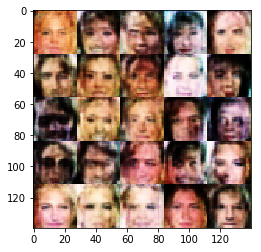

Epoch 1/1.	 Discriminator Loss: 0.9058;  Generator Loss: 1.8337
Epoch 1/1.	 Discriminator Loss: 1.2867;  Generator Loss: 3.1835
Epoch 1/1.	 Discriminator Loss: 1.6848;  Generator Loss: 0.3936
Epoch 1/1.	 Discriminator Loss: 0.8099;  Generator Loss: 2.1081
Epoch 1/1.	 Discriminator Loss: 1.2387;  Generator Loss: 0.9987
Epoch 1/1.	 Discriminator Loss: 1.0955;  Generator Loss: 3.3254
Epoch 1/1.	 Discriminator Loss: 1.1597;  Generator Loss: 3.4002
Epoch 1/1.	 Discriminator Loss: 0.9505;  Generator Loss: 1.1422
Epoch 1/1.	 Discriminator Loss: 1.3709;  Generator Loss: 0.6331
Epoch 1/1.	 Discriminator Loss: 0.9188;  Generator Loss: 1.4722


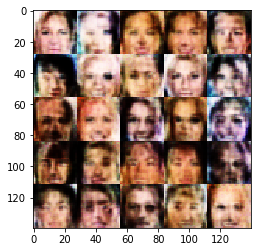

Epoch 1/1.	 Discriminator Loss: 1.5644;  Generator Loss: 0.5514
Epoch 1/1.	 Discriminator Loss: 1.0638;  Generator Loss: 1.3007
Epoch 1/1.	 Discriminator Loss: 1.5115;  Generator Loss: 0.6215
Epoch 1/1.	 Discriminator Loss: 1.1198;  Generator Loss: 1.4051
Epoch 1/1.	 Discriminator Loss: 1.1727;  Generator Loss: 0.9587
Epoch 1/1.	 Discriminator Loss: 1.6720;  Generator Loss: 0.4222
Epoch 1/1.	 Discriminator Loss: 2.2908;  Generator Loss: 0.1949
Epoch 1/1.	 Discriminator Loss: 1.1280;  Generator Loss: 2.4134
Epoch 1/1.	 Discriminator Loss: 0.9023;  Generator Loss: 1.5543
Epoch 1/1.	 Discriminator Loss: 1.2078;  Generator Loss: 1.1160


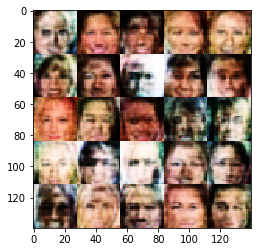

Epoch 1/1.	 Discriminator Loss: 1.5132;  Generator Loss: 0.5397
Epoch 1/1.	 Discriminator Loss: 1.2312;  Generator Loss: 0.8343
Epoch 1/1.	 Discriminator Loss: 1.4243;  Generator Loss: 0.6319
Epoch 1/1.	 Discriminator Loss: 1.1637;  Generator Loss: 0.7477
Epoch 1/1.	 Discriminator Loss: 1.0265;  Generator Loss: 1.9708
Epoch 1/1.	 Discriminator Loss: 1.4115;  Generator Loss: 0.6573
Epoch 1/1.	 Discriminator Loss: 1.4844;  Generator Loss: 2.0559
Epoch 1/1.	 Discriminator Loss: 1.2681;  Generator Loss: 1.7714
Epoch 1/1.	 Discriminator Loss: 1.1160;  Generator Loss: 1.1493
Epoch 1/1.	 Discriminator Loss: 0.7098;  Generator Loss: 1.8244


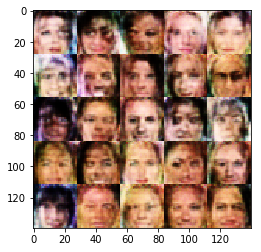

Epoch 1/1.	 Discriminator Loss: 1.3786;  Generator Loss: 0.7137
Epoch 1/1.	 Discriminator Loss: 0.8690;  Generator Loss: 1.4806
Epoch 1/1.	 Discriminator Loss: 1.7126;  Generator Loss: 1.3111
Epoch 1/1.	 Discriminator Loss: 1.3189;  Generator Loss: 0.8306
Epoch 1/1.	 Discriminator Loss: 0.9600;  Generator Loss: 1.2383
Epoch 1/1.	 Discriminator Loss: 1.2645;  Generator Loss: 2.5093
Epoch 1/1.	 Discriminator Loss: 1.1848;  Generator Loss: 4.1254
Epoch 1/1.	 Discriminator Loss: 0.9443;  Generator Loss: 1.2935
Epoch 1/1.	 Discriminator Loss: 1.2858;  Generator Loss: 2.9628
Epoch 1/1.	 Discriminator Loss: 1.2275;  Generator Loss: 0.9896


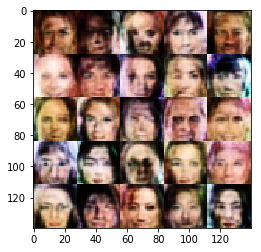

Epoch 1/1.	 Discriminator Loss: 1.4404;  Generator Loss: 0.6202
Epoch 1/1.	 Discriminator Loss: 1.0015;  Generator Loss: 3.8804
Epoch 1/1.	 Discriminator Loss: 1.6612;  Generator Loss: 0.4337
Epoch 1/1.	 Discriminator Loss: 1.1710;  Generator Loss: 1.0960
Epoch 1/1.	 Discriminator Loss: 1.6040;  Generator Loss: 0.5615
Epoch 1/1.	 Discriminator Loss: 1.6238;  Generator Loss: 0.5810
Epoch 1/1.	 Discriminator Loss: 1.0745;  Generator Loss: 2.4055
Epoch 1/1.	 Discriminator Loss: 1.0450;  Generator Loss: 1.9960
Epoch 1/1.	 Discriminator Loss: 2.2018;  Generator Loss: 0.2118
Epoch 1/1.	 Discriminator Loss: 0.9950;  Generator Loss: 1.8848


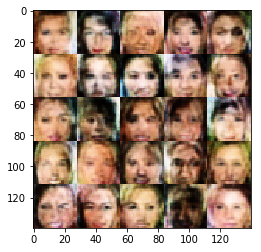

Epoch 1/1.	 Discriminator Loss: 1.1663;  Generator Loss: 0.9299
Epoch 1/1.	 Discriminator Loss: 1.2920;  Generator Loss: 0.8013
Epoch 1/1.	 Discriminator Loss: 1.8058;  Generator Loss: 0.3705
Epoch 1/1.	 Discriminator Loss: 0.9763;  Generator Loss: 1.7948
Epoch 1/1.	 Discriminator Loss: 1.2836;  Generator Loss: 1.4571
Epoch 1/1.	 Discriminator Loss: 2.2153;  Generator Loss: 0.2310
Epoch 1/1.	 Discriminator Loss: 1.0213;  Generator Loss: 2.0130
Epoch 1/1.	 Discriminator Loss: 2.3224;  Generator Loss: 0.2114
Epoch 1/1.	 Discriminator Loss: 1.0037;  Generator Loss: 1.4464
Epoch 1/1.	 Discriminator Loss: 1.5345;  Generator Loss: 1.2463


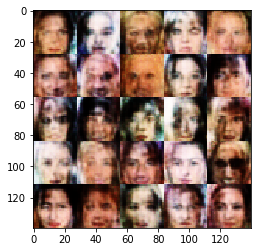

Epoch 1/1.	 Discriminator Loss: 1.4438;  Generator Loss: 2.8001
Epoch 1/1.	 Discriminator Loss: 1.0163;  Generator Loss: 1.5044
Epoch 1/1.	 Discriminator Loss: 0.9944;  Generator Loss: 2.6974
Epoch 1/1.	 Discriminator Loss: 1.2706;  Generator Loss: 0.8768
Epoch 1/1.	 Discriminator Loss: 2.4017;  Generator Loss: 0.1717
Epoch 1/1.	 Discriminator Loss: 1.4850;  Generator Loss: 0.8412
Epoch 1/1.	 Discriminator Loss: 1.2498;  Generator Loss: 1.0155
Epoch 1/1.	 Discriminator Loss: 1.2222;  Generator Loss: 1.8938
Epoch 1/1.	 Discriminator Loss: 1.1281;  Generator Loss: 1.3818
Epoch 1/1.	 Discriminator Loss: 1.5983;  Generator Loss: 0.5660


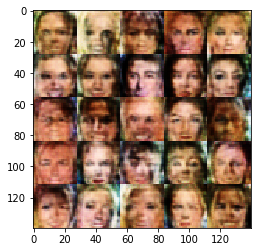

Epoch 1/1.	 Discriminator Loss: 1.6496;  Generator Loss: 1.3285
Epoch 1/1.	 Discriminator Loss: 1.1205;  Generator Loss: 0.9940
Epoch 1/1.	 Discriminator Loss: 1.0239;  Generator Loss: 1.0789
Epoch 1/1.	 Discriminator Loss: 1.3976;  Generator Loss: 1.2262
Epoch 1/1.	 Discriminator Loss: 1.6422;  Generator Loss: 0.4513
Epoch 1/1.	 Discriminator Loss: 1.3239;  Generator Loss: 0.7980
Epoch 1/1.	 Discriminator Loss: 1.7012;  Generator Loss: 1.1662
Epoch 1/1.	 Discriminator Loss: 1.0210;  Generator Loss: 1.8852
Epoch 1/1.	 Discriminator Loss: 1.1288;  Generator Loss: 1.7243
Epoch 1/1.	 Discriminator Loss: 1.7668;  Generator Loss: 0.4783


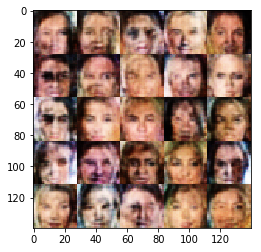

Epoch 1/1.	 Discriminator Loss: 1.4583;  Generator Loss: 1.8703
Epoch 1/1.	 Discriminator Loss: 1.3608;  Generator Loss: 1.3017
Epoch 1/1.	 Discriminator Loss: 1.1085;  Generator Loss: 1.3122
Epoch 1/1.	 Discriminator Loss: 1.4770;  Generator Loss: 0.8039
Epoch 1/1.	 Discriminator Loss: 1.0519;  Generator Loss: 3.0160
Epoch 1/1.	 Discriminator Loss: 2.5828;  Generator Loss: 0.1833
Epoch 1/1.	 Discriminator Loss: 1.4282;  Generator Loss: 0.7192
Epoch 1/1.	 Discriminator Loss: 1.2776;  Generator Loss: 1.2744
Epoch 1/1.	 Discriminator Loss: 1.5961;  Generator Loss: 1.5870
Epoch 1/1.	 Discriminator Loss: 2.2627;  Generator Loss: 0.2109


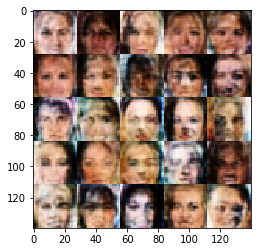

KeyboardInterrupt: 

In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。